ACO - Ant Colony Optimization ou Otimização da Colônia de Formigas é uma metaheurística proposta pelo pesquisador Marco Dorigo em 1992 para resolver problemas de otimização inspirado no comportamento das formigas ao saírem de sua colônia para encontrar comida, buscando a solução de problemas computacionais que envolvem procura de caminhos em grafos.

Dorigo, M.; Maniezzo, V.; Colorni, A. Ant system: optimization by a colony of cooperating agents. IEEE Transactions on Systems, Man, and Cybernetics (Volume: 26, Issue: 1). https://doi.org/10.1109/3477.484436, 1996.

In [81]:
#instala biblioteca Orange Canvas
!pip install Orange3

In [82]:
#importa bibliotecas
import Orange
from numpy.random import choice
from scipy import spatial
import matplotlib.pyplot as plt
import random
import math
from sklearn import metrics

In [83]:
#define os hiperparâmetros
DIMENSOES = 2 #determina a quantidade de dimensões do problema
ITERACOES = 200 #quantiddade máxima de ciclos (episódios) especificando quantas explorações podem ser realizadas
COLONIA = 40 #tamanho da população correspondente ao número de formigas no formigueiro
FONTES_ALIMENTACAO = 20 #quantidade de pontos no grafo representando as coordenadas das dimensões do problema
E1 = -100 #extremo esquerdo eixo x
E2 = 100 #extremo direito eixo x
E3 = -100 #extremo inferior eixo y
E4 = 100 #extremo superior eixo y
LIMITES = [E1,E4] #(bound) determina os valores mínimos e máximos do espaço de busca
FCUSTO = 'caminho' #(fitness) define a aptidão da formiga na possível solução do problema
E = 0.2 #taxa de evaporação do feromônio nos caminhos
ALFA = 0.5 #coeficente de importância da qtde feromônio para determinar probabilidade de escolha do caminho
BETA = 0.7 #coeficente de importância do caminho para determinar a probabilidade de escolha do caminho

In [84]:
#importa dados
from google.colab import files
files.upload()

Saving rotas.csv to rotas.csv


{'rotas.csv': b'DIRIGIBILIDADE,ROTAS,DISTANCIA,FALHAS,LOMBADAS,ILUMINACAO,SINALIZACAO,PEDAGIOS,POSTOPOLICIAL\r\ncontinuous,string,continuous,continuous,continuous,continuous,continuous,0.0 1.0,discrete\r\nclass,meta,,,,,,,\r\n3.0,R1,159.0,20.0,16.0,4.0,3.0,1.0,0.0\r\n2.0,R2,131.0,3.0,2.0,1.0,6.0,1.0,0.0\r\n3.0,R3,141.0,2.0,27.0,3.0,57.0,1.0,0.0\r\n3.0,R4,269.0,13.0,20.0,1.0,93.0,0.0,0.0\r\n2.0,R5,182.0,27.0,10.0,4.0,78.0,1.0,0.0\r\n3.0,R6,225.0,12.0,18.0,5.0,46.0,0.0,0.0\r\n2.0,R7,264.0,20.0,13.0,2.0,89.0,0.0,0.0\r\n1.0,R8,148.0,11.0,26.0,4.0,59.0,0.0,0.0\r\n3.0,R9,245.0,18.0,3.0,2.0,58.0,0.0,0.0\r\n1.0,R10,203.0,1.0,27.0,4.0,33.0,0.0,0.0\r\n1.0,R11,222.0,29.0,20.0,3.0,21.0,0.0,0.0\r\n2.0,R12,203.0,30.0,7.0,4.0,51.0,0.0,0.0\r\n1.0,R13,296.0,10.0,27.0,3.0,13.0,0.0,0.0\r\n2.0,R14,168.0,30.0,24.0,3.0,63.0,0.0,0.0\r\n1.0,R15,201.0,22.0,7.0,3.0,33.0,1.0,0.0\r\n2.0,R16,278.0,15.0,17.0,2.0,55.0,0.0,0.0\r\n3.0,R17,182.0,10.0,5.0,5.0,95.0,1.0,0.0\r\n2.0,R18,265.0,10.0,29.0,1.0,14.0,1.0,0.0\r\n1

In [85]:
#instancia objeto de dados com base no caminho gerado na importação do arquivo
dados = Orange.data.Table("/content/rotas.csv")

In [86]:
#explora os metadados e dados da arquivo importado
qtde_campos = len(dados.domain.attributes)
qtde_cont = sum(1 for a in dados.domain.attributes if a.is_continuous)
qtde_disc = sum(1 for a in dados.domain.attributes if a.is_discrete)
print("%d metadados: %d continuos, %d discretos" % (qtde_campos, qtde_cont, qtde_disc))
print("Nome dos metadados:", ", ".join(dados.domain.attributes[i].name for i in range(qtde_campos)),)
dados.domain.attributes #explora os domínios dos atributos (campos da base de dados)
print("Registros:", len(dados)) #explora os dados (quantidade de registros da base de dados)
i = 0 #exibe os primeiros registros para análise dos dados importados
for d in dados[:20]:
  i += 1
  print(i, d)

7 metadados: 5 continuos, 2 discretos
Nome dos metadados: DISTANCIA, FALHAS, LOMBADAS, ILUMINACAO, SINALIZACAO, PEDAGIOS, POSTOPOLICIAL
Registros: 5119
1 [159.0, 20.0, 16.0, 4.0, 3.0, 1.0, 0.0 | 3.0] {R1}
2 [131.0, 3.0, 2.0, 1.0, 6.0, 1.0, 0.0 | 2.0] {R2}
3 [141.0, 2.0, 27.0, 3.0, 57.0, 1.0, 0.0 | 3.0] {R3}
4 [269.0, 13.0, 20.0, 1.0, 93.0, 0.0, 0.0 | 3.0] {R4}
5 [182.0, 27.0, 10.0, 4.0, 78.0, 1.0, 0.0 | 2.0] {R5}
6 [225.0, 12.0, 18.0, 5.0, 46.0, 0.0, 0.0 | 3.0] {R6}
7 [264.0, 20.0, 13.0, 2.0, 89.0, 0.0, 0.0 | 2.0] {R7}
8 [148.0, 11.0, 26.0, 4.0, 59.0, 0.0, 0.0 | 1.0] {R8}
9 [245.0, 18.0, 3.0, 2.0, 58.0, 0.0, 0.0 | 3.0] {R9}
10 [203.0, 1.0, 27.0, 4.0, 33.0, 0.0, 0.0 | 1.0] {R10}
11 [222.0, 29.0, 20.0, 3.0, 21.0, 0.0, 0.0 | 1.0] {R11}
12 [203.0, 30.0, 7.0, 4.0, 51.0, 0.0, 0.0 | 2.0] {R12}
13 [296.0, 10.0, 27.0, 3.0, 13.0, 0.0, 0.0 | 1.0] {R13}
14 [168.0, 30.0, 24.0, 3.0, 63.0, 0.0, 0.0 | 2.0] {R14}
15 [201.0, 22.0, 7.0, 3.0, 33.0, 1.0, 0.0 | 1.0] {R15}
16 [278.0, 15.0, 17.0, 2.0, 55.0, 0

In [87]:
#cria arrays das dimensões do problema a ser otimizado
vetor1 = []
vetor2 = []
vetor3 = []
vetor4 = []
vetor5 = []
vetor6 = []
i = 0
for d in dados[:COLONIA]:
  vetor1.append(d[0])
  vetor2.append(d[1])
  vetor3.append(d[2])
  vetor4.append(d[3])
  vetor5.append(d[4])
  vetor6.append(d[5])
  print("id:",i,"vetor1:",vetor1[i],"vetor2:",vetor2[i],"vetor3:",vetor3[i],"vetor4:",vetor4[i],"vetor5:",vetor5[i],"vetor6:",vetor6[i])
  vet1 = vetor1[i]
  vet2 = vetor2[i]
  vet3 = vetor3[i]
  vet4 = vetor4[i]
  vet5 = vetor5[i]
  vet6 = vetor6[i]
  i += 1

id: 0 vetor1: 159.0 vetor2: 20.0 vetor3: 16.0 vetor4: 4.0 vetor5: 3.0 vetor6: 1.0
id: 1 vetor1: 131.0 vetor2: 3.0 vetor3: 2.0 vetor4: 1.0 vetor5: 6.0 vetor6: 1.0
id: 2 vetor1: 141.0 vetor2: 2.0 vetor3: 27.0 vetor4: 3.0 vetor5: 57.0 vetor6: 1.0
id: 3 vetor1: 269.0 vetor2: 13.0 vetor3: 20.0 vetor4: 1.0 vetor5: 93.0 vetor6: 0.0
id: 4 vetor1: 182.0 vetor2: 27.0 vetor3: 10.0 vetor4: 4.0 vetor5: 78.0 vetor6: 1.0
id: 5 vetor1: 225.0 vetor2: 12.0 vetor3: 18.0 vetor4: 5.0 vetor5: 46.0 vetor6: 0.0
id: 6 vetor1: 264.0 vetor2: 20.0 vetor3: 13.0 vetor4: 2.0 vetor5: 89.0 vetor6: 0.0
id: 7 vetor1: 148.0 vetor2: 11.0 vetor3: 26.0 vetor4: 4.0 vetor5: 59.0 vetor6: 0.0
id: 8 vetor1: 245.0 vetor2: 18.0 vetor3: 3.0 vetor4: 2.0 vetor5: 58.0 vetor6: 0.0
id: 9 vetor1: 203.0 vetor2: 1.0 vetor3: 27.0 vetor4: 4.0 vetor5: 33.0 vetor6: 0.0
id: 10 vetor1: 222.0 vetor2: 29.0 vetor3: 20.0 vetor4: 3.0 vetor5: 21.0 vetor6: 0.0
id: 11 vetor1: 203.0 vetor2: 30.0 vetor3: 7.0 vetor4: 4.0 vetor5: 51.0 vetor6: 0.0
id: 12 vet

In [88]:
#função custo ou objetivo ou aptidão ou otimização ou fitness - usada para buscar o melhor ponto dentro de um espaço de buscao (melhor global) sem ficar preso em um melhor local
def fcusto(problema, possivel_solucao, alfa=0, beta=0, gama=0, delta=0, epsilon=0, zeta=0):
  total = 0.0
  if problema == 'rosenbrock':
    for i in range(DIMENSOES-1):
      total += 100*(possivel_solucao[i+1] - possivel_solucao[i]**2)**2 + (1-possivel_solucao[i])**2
  elif problema == 'esfera':
    for i in range(DIMENSOES):
      total += possivel_solucao[i]**2
  elif problema == 'custo':
    for i in range(DIMENSOES-1):
      total += 1 / abs(sum([coord ** 2 for coord in possivel_solucao]))
  elif problema == 'caminho':
    denominador = sum([(caminho.feromonio)**ALFA * (1 / caminho.comprimento)**BETA for caminho in possivel_solucao])
    distribuicao_probabilidades = None
    if denominador == 0:
      distribuicao_probabilidades = [1 / len(possivel_solucao) for _ in possivel_solucao]
    else:
      distribuicao_probabilidades = [((caminho.feromonio)**ALFA * (1 / caminho.comprimento)**BETA) / denominador for caminho in possivel_solucao]
    total = choice(possivel_solucao, 1, p=distribuicao_probabilidades)[0]
  elif problema == "distância":
    total = 0
    for i in range(COLONIA):
      if i < COLONIA - 1:
        total += pontos[possivel_solucao[i]].distancia(pontos[possivel_solucao[i+1]])
      else:
        total += pontos[possivel_solucao[i]].distancia(pontos[possivel_solucao[0]])
    total = 1/total
  else:
    print('Problema não encontrado!')
  return total

In [89]:
#formiga - unidade base da otimização, responsável por depositar o feromônio pelos caminhos que percorrem para indicar a qualidade do mesmo
class Formiga:
  def __init__(self, ponto_atual):
    self.ponto_atual = ponto_atual
    self.rota = [ponto_atual]
  def andar(self, ponto):
    self.ponto_atual = ponto
    self.rota.append(ponto)

In [90]:
#ponto - representação de uma coordenada no espaço
class Ponto:
  def __init__(self, x, y):
    self.x = x
    self.y = y

In [91]:
#caminho - ligação entre dois pontos
class Caminho:
  def __init__(self, ponto_i, ponto_j):
    self.ponto_i = ponto_i
    self.ponto_j = ponto_j
    self.comprimento = math.sqrt((ponto_i.x - ponto_j.x)**2 + (ponto_i.y - ponto_j.y)**2)
    self.feromonio = 0
    self.formigas_passantes = []
  def contem(self, formiga):
    if self.ponto_i == formiga.ponto_atual:
      return self.ponto_j not in formiga.rota
    elif self.ponto_j == formiga.ponto_atual:
      return self.ponto_i not in formiga.rota
    else:
      return False
  def ponto_adjacente(self, ponto):
    if self.ponto_i == ponto:
      return self.ponto_j
    elif self.ponto_j == ponto:
      return self.ponto_i
    else:
      return None

In [92]:
#grafo - representação de um conjunto de pontos ligados por caminhos
class Grafo:
  def __init__(self, caminhos):
    self.caminhos = caminhos
    self.melhor_rota = []
    self.comprimento_melhor_rota = 0
  def atualizas_melhor_rota(self, melhor_rota):
    self.melhor_rota = melhor_rota
    self.comprimento_melhor_rota = sum([math.sqrt((i.x - j.x)**2 + (i.y - j.y)**2) for [i, j] in melhor_rota])
  def possiveis_caminhos(self, formiga):
    return [caminho for caminho in self.caminhos if caminho.contem(formiga)]

In [121]:
#inicializa pontos - fontes de alimentação das formigas que correspondem dimensões do problema
pontos = []
for i in range(FONTES_ALIMENTACAO):
  vet2 = vetor2[i]
  vet3 = vetor3[i]
  pontos.append(Ponto(vet2, vet3))

In [122]:
#inicializa caminhos
caminhos = []
i = 0
while i < FONTES_ALIMENTACAO - 1:
  j = i + 1
  while j < FONTES_ALIMENTACAO:
    caminhos.append(Caminho(pontos[i], pontos[j]))
    j += 1
  i += 1

In [123]:
#calcula rota (fitness)
def distancia_rota(rota):
  distancia_rota = 0
  for i in range(0, len(rota) - 1):
    distancia = math.sqrt((rota[i].x - rota[i + 1].x)**2 + (rota[i].y - rota[i + 1].y)**2)
    distancia_rota += distancia
  return distancia_rota

In [124]:
#calcula a atualização do feromônio
def atualizar_feromonios(caminhos):
  for caminho in caminhos:
    soma_heuristica = sum([1 / distancia_rota(formiga.rota) for formiga in caminho.formigas_passantes])
    caminho.feromonio = (1 - E) * caminho.feromonio + soma_heuristica # p = evaporação do feromônico
    caminho.formigas_passantes = []

In [125]:
#calcula o movimento das formigas
def movimentar_formiga(formiga, grafo):
  while True:
    possiveis_caminhos = grafo.possiveis_caminhos(formiga)
    if possiveis_caminhos == []:
      break
    caminho_escolhido = fcusto(FCUSTO,possiveis_caminhos)
    caminho_escolhido.formigas_passantes.append(formiga)
    formiga.andar(caminho_escolhido.ponto_adjacente(formiga.ponto_atual))

In [126]:
#plota posições no gráfico
def exibe_grafico(titulo,x,y,x_rota=[],y_rota=[]):
  plt.axis([E1,E2,E3,E4])
  for i in range(COLONIA):
    plt.plot(x, y, 'ro')
  plt.plot(0,0, marker='*', markersize=10, color='b')
  plt.plot(x,y, color='c', linewidth=0.2)
  if (len(x_rota)!=0):
    plt.plot(x_rota,y_rota, color='r', linewidth=0.6)
  plt.title(titulo)
  plt.show()

In [127]:
#inicializa população (colonia)
def inicializar_colonia():
  formigas = []
  for _ in range(COLONIA):
    formigas.append(Formiga(random.choice(pontos)))
  return formigas

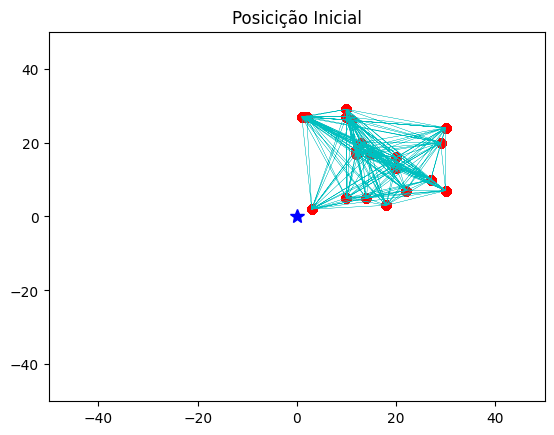

In [128]:
#posiciona as fontes de alimentação das formigas no espaço de busca
E1 = -50 #extremo esquerdo eixo x
E2 = 50 #extremo direito eixo x
E3 = -50 #extremo inferior eixo y
E4 = 50 #extremo superior eixo y
grafo = Grafo(caminhos)
x = []
y = []
for caminho in caminhos:
  x_i = caminho.ponto_i.x
  x_j = caminho.ponto_j.x
  y_i = caminho.ponto_i.y
  y_j = caminho.ponto_j.y
  x_texto = (x_i + x_j) / 2
  y_texto = (y_i + y_j) / 2
  x.append(x_i)
  x.append(x_j)
  y.append(y_i)
  y.append(y_j)
exibe_grafico('Posicição Inicial',x,y)
gx = x
gy = y

In [113]:
#otimização ACO
melhor_rota = None
distancia_melhor_sequencia = 0
lista_melhores_valores = []
convergencia = []
for _ in range(ITERACOES):
  print("Iteração: {:.0f}".format(_+1))
  formigas = inicializar_colonia()
  for formiga in formigas:
    movimentar_formiga(formiga, grafo)
    if melhor_rota is None or distancia_rota(melhor_rota) > distancia_rota(formiga.rota):
      melhor_rota = formiga.rota
      distancia_melhor_sequencia = distancia_rota(formiga.rota)
      lista_melhores_valores.append(distancia_melhor_sequencia)
  atualizar_feromonios(grafo.caminhos)
  x = []
  y = []
  for caminho in caminhos:
    x_i = caminho.ponto_i.x
    x_j = caminho.ponto_j.x
    y_i = caminho.ponto_i.y
    y_j = caminho.ponto_j.y
    x_texto = (x_i + x_j) / 2
    y_texto = (y_i + y_j) / 2
    x.append(x_i)
    x.append(x_j)
    y.append(y_i)
    y.append(y_j)
  x_rota = []
  y_rota = []
  for ponto in melhor_rota:
    x_rota.append(ponto.x)
    y_rota.append(ponto.y)
  exibe_grafico('Melhor Solução: {:.5f}'.format(distancia_melhor_sequencia),x,y,x_rota,y_rota)
  convergencia.append(distancia_melhor_sequencia)

Iteração: 1


ZeroDivisionError: ignored

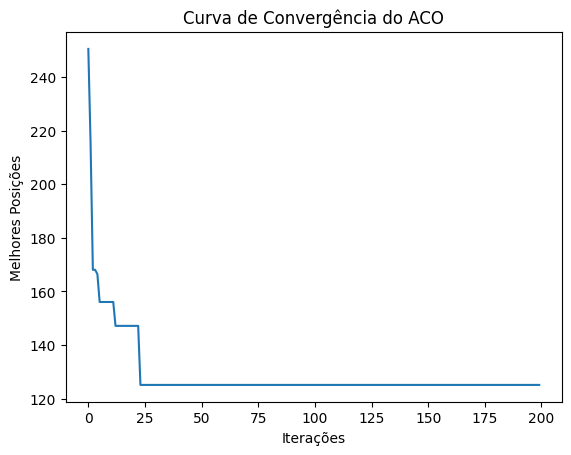

In [102]:
#exibe curva de convergência das formigas
x = []
y = []
for i in range(ITERACOES):
  x.append(i)
  y.append(convergencia[i])
plt.title("Curva de Convergência do ACO")
plt.xlabel("Iterações")
plt.ylabel("Melhores Posições")
plt.plot(x,y)
plt.show()

In [103]:
#exibe os valores da convergência
for i in range(ITERACOES): print("iteração:",i,"posição:",convergencia[i])

iteração: 0 posição: 250.49592122326723
iteração: 1 posição: 215.06461635441218
iteração: 2 posição: 168.06603968687608
iteração: 3 posição: 168.06603968687608
iteração: 4 posição: 166.45007113560956
iteração: 5 posição: 156.05521184628674
iteração: 6 posição: 156.05521184628674
iteração: 7 posição: 156.05521184628674
iteração: 8 posição: 156.05521184628674
iteração: 9 posição: 156.05521184628674
iteração: 10 posição: 156.05521184628674
iteração: 11 posição: 156.05521184628674
iteração: 12 posição: 147.14035583331136
iteração: 13 posição: 147.14035583331136
iteração: 14 posição: 147.14035583331136
iteração: 15 posição: 147.14035583331136
iteração: 16 posição: 147.14035583331136
iteração: 17 posição: 147.14035583331136
iteração: 18 posição: 147.14035583331136
iteração: 19 posição: 147.14035583331136
iteração: 20 posição: 147.14035583331136
iteração: 21 posição: 147.14035583331136
iteração: 22 posição: 147.14035583331136
iteração: 23 posição: 125.10232230855817
iteração: 24 posição: 125.